# Notes for user:

*   While ubiquitous, textual sources of information such as company reports, social media posts, etc. are hardly
included in prediction algorithms for time series, despite the relevant information they may contain. 
*   In this model, daily news headlines and tweets filtering of USA, Britian and COVID-19 are leveraged to predict time series of USD/GBP with a single pipeline.
*   Two methods of numerical representation of text are considered, namely traditional Term Frequency - 
Inverse Document Frequency (TF-IDF) and Count Vectorize.
*   Corpus: Collection of documents



# Importing News Headings API


In [ ]:
!pip install pandas OpenBlender matplotlib wordcloud

In [ ]:
import OpenBlender
import pandas as pd
import json

action = 'API_getObservationsFromDataset'

# ANCHOR: 'USD/GBP'

parameters = { 
  'token':'YOUR TOKEN',
	'id_dataset':'5f1db9989516291eeabd3c71',
	'consumption_confirmation':'on',
	'blends':[] 
}
        
us_gbp = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
us_gbp.reset_index(drop=True, inplace=True)
us_gbp.head()
us_gbp.tail()

Task ID: '5f1ef08d0895fafb4a9d8d4b'.
Total estimated consumption: 20376.99 processing units.
Continue?  [y] yes 	 [n] noy
Task confirmed. Starting download..
CSV will be stored in: 1595863184.3663752.csv
100.0 % completed.


,timestamp,spot_price
369,1549411200,1.2963
370,1549324800,1.2940
371,1549238400,1.3085
372,1548979200,1.3093
373,1548892800,1.3152


In [ ]:
import OpenBlender
import pandas as pd
import json

action = 'API_getOpenTextData'
parameters = {
    'token':'YOUR TOKEN',
    'consumption_confirmation':'on',
    'date_filter':{"start_date":"2019-12-31T06:00:00.000Z", 
                   "end_date":"2020-06-30T06:00:00.000Z"},
    'sources':[
                # Wall Street Journal
               {'id_dataset' : '5e2ef74e9516294390e810a9', 
                 'features' : ['text']},
                # ABC News Headlines
               {'id_dataset':"5d8848e59516294231c59581", 
                'features' : ["headline", "title"]},
                # USA Today Twitter
               {'id_dataset' : "5e32fd289516291e346c1726", 
                'features' : ["text"]},
                # CNN News
               {'id_dataset' : "5d571b9e9516293a12ad4f5c", 
                'features' : ["headline", "title"]}
    ],
    'aggregate_in_time_interval' : {
              'time_interval_size' : 60 * 60 * 24
    },
    'text_filter_search':['covid', 'coronavirus', 'ncov'],
    'add_date' : 'date'    
}
covid_news_headlines = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
covid_news_headlines.reset_index(drop=True, inplace=True)

Task ID: '5f1ef09190eaa07497e356c6'.
Total estimated consumption: 48234.87 processing units.
Continue?  [y] yes 	 [n] noy
Task confirmed. Starting download..
CSV will be stored in: 1595863188.2930484.csv
100.0 % completed.


In [ ]:
covid_news_headlines.head()

,source,timestamp.date,timestamp,source_lst
0,bars have emerged as problem spots in a sur...,2020-06-30,1593475200,"[stocks climbed, with the dow up more than 550..."
1,students across much of the world have retu...,2020-06-29,1593388800,[record hospitalizations for covid-19 are prom...
2,weve gotta get her through this a boston su...,2020-06-28,1593302400,[the claim doctors warn covid19 may trigger di...
3,at a japanese host club you can get up clos...,2020-06-27,1593216000,[adriana rice-leiva had one child and another ...
4,from wsjopinion new zealands strategy towar...,2020-06-26,1593129600,[it turns out the covid-19 pandemic has meant ...


In [ ]:
covid_news_headlines.tail()

,source,timestamp.date,timestamp,source_lst
178,,2020-01-04,1578096000,[]
179,,2020-01-03,1578009600,[]
180,,2020-01-02,1577923200,[]
181,,2020-01-01,1577836800,[]
182,,2019-12-31,1577750400,[]


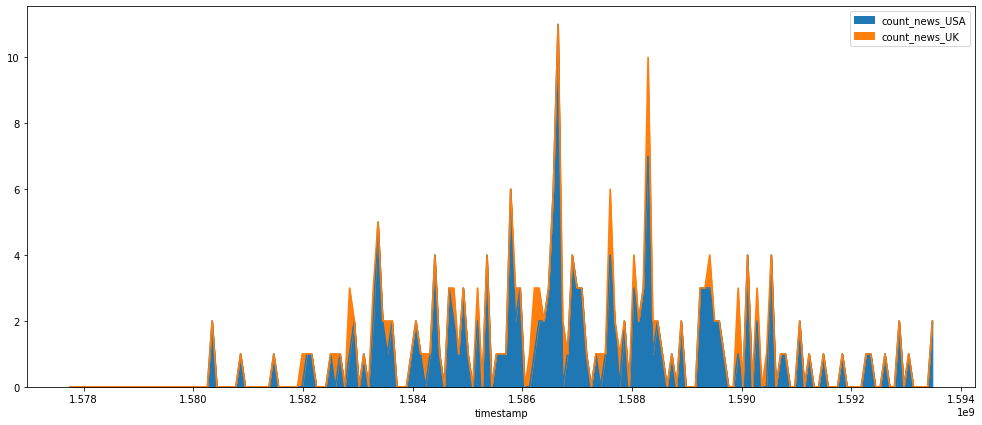

In [ ]:
# Mention count for some countries of interest.
# interest_countries = ['USA', 'China', 'UK','Italy', 'Brazil']
interest_countries = ['USA', 'UK']
for country in interest_countries:
    covid_news_headlines['count_news_' + country] = [len([text for text in daily_lst if country.lower() in text]) for daily_lst in covid_news_headlines['source_lst']]
covid_news_headlines.reindex(index=covid_news_headlines.index[::-1]).plot(x = 'timestamp', y = [col for col in covid_news_headlines.columns if 'count' in col], figsize=(17,7), kind='area')

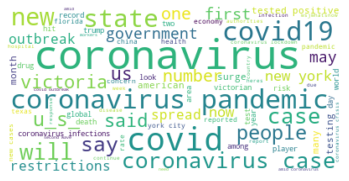

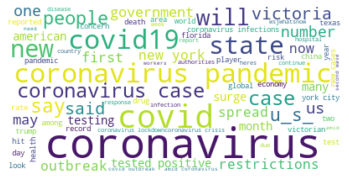

In [ ]:
# word cloud from the last 20 days of news
from matplotlib import pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.figure()
plt.imshow(WordCloud(max_font_size=50, max_words=80, background_color="white").generate(' '.join([val for val in covid_news_headlines['source'][0: 20]])), interpolation="bilinear")
plt.axis("off")
plt.show()
plt.figure()
plt.imshow(WordCloud(max_font_size=50, max_words=80, background_color="white").generate(' '.join([val for val in covid_news_headlines['source'][0: 20]])), interpolation="bilinear")
plt.axis("off")
plt.show()

# Cleaning & Collating Data

In [ ]:
# Merging timestamp from two tables
dataset = pd.merge(left=covid_news_headlines, left_on='timestamp',
         right=us_gbp, right_on='timestamp')
dataset.head()

,source,timestamp.date,timestamp,source_lst,count_news_USA,count_news_UK,spot_price
0,bars have emerged as problem spots in a sur...,2020-06-30,1593475200,"[stocks climbed, with the dow up more than 550...",2,0,1.2359
1,students across much of the world have retu...,2020-06-29,1593388800,[record hospitalizations for covid-19 are prom...,0,0,1.2268
2,from wsjopinion new zealands strategy towar...,2020-06-26,1593129600,[it turns out the covid-19 pandemic has meant ...,0,0,1.2320
3,plexiglass artisan stefano antonelli has be...,2020-06-25,1593043200,[companies and academic labs are racing to cre...,1,0,1.2406
4,six players and four staff members on the n...,2020-06-24,1592956800,[dr fauci contradicts president trumps covid19...,0,0,1.2450


In [ ]:
# Need to filter so that only america and covid are seen
import numpy as np
# stored as a 2d array
news = np.array(dataset['source_lst'])
print(news[0][0])
print(news[1][5])
# print(news[48][0]) out of range?
print(news[45][0])


stocks climbed, with the dow up more than 550 points, as investors weighed a rise in coronavirus cases with hopes for more stimulus from central banks
a new study has found further evidence of a correlation between severe cases of covid19 andbrain complications but researchers say they still arent sure whether those complications are directly caused by the disease
a lawsuit alleges cal-maine foods has sold eggs at over 300% of their normal cost during the coronavirus pandemic


In [ ]:
# 2D array
# Look for first array
# Go through every sentense in the first array, if ['USA'] comes up then save if not disgard
# Go through every sentense in the first array, if ['UK'] comes up then save if not disgard

# Tokenizing


*   When we work on text, we can use the 'Bag of Words' model to represent a document.
*   In the BOW model, each document can be thought of as a bag of words
*   Splitting a document into the component words like this is called 'tokenizing'.
*   So the documents are now tokenized, but how do we convert a tokenized BOW into numbers?
*   There are afew strategies, one simple strategy could be to create a vector of all possible words and for each document count how many times each word appears



In [ ]:
msg_1a = news[0][0]
msg_1b = news[0][1]

In [ ]:
# words tokenized (no weird characters)
msg_1a = msg_1a.split(" ")
msg_1b = msg_1b.split(" ")

In [ ]:
msg_1b

['new',
 'coronavirus',
 'test',
 'introduced',
 'as',
 'spike',
 'in',
 'victorian',
 'cases',
 'worsens']

# Creating vector of all possible words in document

In [ ]:
# Sets elminated duplicates
wordSet = set(msg_1a).union(set(msg_1b))

In [ ]:
# All words in all bags/documents
# List of all unique words in corpus
wordSet

{'550',
 'a',
 'as',
 'banks',
 'cases',
 'central',
 'climbed,',
 'coronavirus',
 'dow',
 'for',
 'from',
 'hopes',
 'in',
 'introduced',
 'investors',
 'more',
 'new',
 'points,',
 'rise',
 'spike',
 'stimulus',
 'stocks',
 'test',
 'than',
 'the',
 'up',
 'victorian',
 'weighed',
 'with',
 'worsens'}

In [ ]:
# I'll create dictionaries to keep my word counts
wordDictA = dict.fromkeys(wordSet,0)
wordDictB = dict.fromkeys(wordSet,0)

In [ ]:

wordDictA

{'550': 0,
 'a': 0,
 'as': 0,
 'banks': 0,
 'cases': 0,
 'central': 0,
 'climbed,': 0,
 'coronavirus': 0,
 'dow': 0,
 'for': 0,
 'from': 0,
 'hopes': 0,
 'in': 0,
 'introduced': 0,
 'investors': 0,
 'more': 0,
 'new': 0,
 'points,': 0,
 'rise': 0,
 'spike': 0,
 'stimulus': 0,
 'stocks': 0,
 'test': 0,
 'than': 0,
 'the': 0,
 'up': 0,
 'victorian': 0,
 'weighed': 0,
 'with': 0,
 'worsens': 0}

In [ ]:
# Count the words in my bags
for word in msg_1a:
  wordDictA[word]+=1
for word in msg_1b:
  wordDictB[word]+=1

In [ ]:
wordDictA

{'550': 1,
 'a': 1,
 'as': 1,
 'banks': 1,
 'cases': 1,
 'central': 1,
 'climbed,': 1,
 'coronavirus': 1,
 'dow': 1,
 'for': 1,
 'from': 1,
 'hopes': 1,
 'in': 1,
 'introduced': 0,
 'investors': 1,
 'more': 2,
 'new': 0,
 'points,': 1,
 'rise': 1,
 'spike': 0,
 'stimulus': 1,
 'stocks': 1,
 'test': 0,
 'than': 1,
 'the': 1,
 'up': 1,
 'victorian': 0,
 'weighed': 1,
 'with': 2,
 'worsens': 0}

In [ ]:
# View as matrix
import pandas as pd
pd.DataFrame([wordDictA, wordDictB])

,550,victorian,as,from,worsens,a,more,investors,stocks,"points,",hopes,coronavirus,rise,"climbed,",new,stimulus,in,up,the,with,introduced,dow,test,banks,spike,weighed,than,cases,for,central
0,1,0,1,1,0,1,2,1,1,1,1,1,1,1,0,1,1,1,1,2,0,1,0,1,0,1,1,1,1,1
1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0


# Count Vectorize Breakdown

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from pandas import DataFrame

In [ ]:
# Count Vectorize
# Takes in multiple documents in form of a python list = message_list
# Vectorizer converts from text to numbers
def create_document_term_matrix(message_list, vectorizer):
  # Transforms all messages into numbers
  message_list=[message_list]
  doc_term_matrix = vectorizer.fit_transform(message_list)
  # Converts all into a matrix and return a dataframe
  return DataFrame(doc_term_matrix.toarray(),
                   columns=vectorizer.get_feature_names())

# Method #1 Count Vectorize 

In [ ]:

msg_1 = news[0][0]

In [ ]:
# Bag of words approach where each word in document is separated into tokens
count_vect = CountVectorizer()

In [ ]:
# As you can see vivienne has appeared only once in 0th document, matrix 1 occurs 0 did not occur
# If using as classification task you can use this data as x train and y train data
# Some words are not significant for a classification task such as is, to etc
# Remove these unwanted words from corpus of words or give them a lower value compare to the important words
# We do this by creating a TF – Term frequency and IDF - Indicator Data Frequency
create_document_term_matrix(msg_1, count_vect)

,550,as,banks,cases,central,climbed,coronavirus,dow,for,from,hopes,in,investors,more,points,rise,stimulus,stocks,than,the,up,weighed,with
0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2


# Method #2 TF_IDF Vectorizer


*   A method used to rank words with values of importance
*   The TF-IDF score is going to be: formula



In [ ]:
# TF-IDF is how often a word occurs in a document. 
# If we have multiple occurances of one word we except this value of this word to rise.
# Contains 2 documents 
msg_2 = news[0][0]
print(msg_2)

stocks climbed, with the dow up more than 550 points, as investors weighed a rise in coronavirus cases with hopes for more stimulus from central banks


In [ ]:
# We create an instance of the tfidf vectoriser
tfidf_vect = TfidfVectorizer()


In [ ]:

create_document_term_matrix(msg_2, tfidf_vect)

,550,as,banks,cases,central,climbed,coronavirus,dow,for,from,hopes,in,investors,more,points,rise,stimulus,stocks,than,the,up,weighed,with
0,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.371391,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.371391


# Method #3 TF_IDF Vectorizer

In [ ]:
msg_3 = news[0][2]

In [ ]:
create_document_term_matrix(msg_3, tfidf_vect)

,alarming,and,arizona,businesses,cases,covid19,for,hoping,in,its,like,not,of,reopening,reported,seeing,states,surges,texas,the,were,with
0,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201,0.213201


# Method #4 TF_IDF Vectorizer

In [ ]:
msg_4 = news[0][3]

In [ ]:
create_document_term_matrix(msg_4, tfidf_vect)

,breakfast,chief,conversation,coronavirus,correspondent,discuss,grattan,in,joins,michelle,outbreak,political,recent,rn,the,to,victoria_,with
0,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.436436,0.218218,0.218218,0.218218


# Conclusions


*   Problem with "Creating vector of all possible words in document" is that we use alot of words commonly that dont mean much e.g. the, an, as. The distribution of words in language is a power law distribution, which is the basis for Zipf's law. So if we construct out document matrix out of counts, we end up with numbers that dont contain much information, unless out goal is to se who uses 'the' most often.
*   List item

